# 위성사진 분석
- Multi class

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from PIL import Image
import random

import torch
import torchvision.transforms as T

import timm

from sklearn.metrics import accuracy_score

/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /opt/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# CustomDataset

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, classes, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i, cls in enumerate(classes):
            class_path = os.path.join(root_path, cls)
            img_list = os.listdir(class_path)
            for img in img_list:
                if img != '.DS_Store':
                    img_path = os.path.join(class_path, img)
                    self.data.append((img_path, i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [4]:
classes = ['EO', 'IR', 'SAR']
transforms = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor()
])

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/10/data/train', classes, transforms)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/10/data/val', classes, transforms)
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/10/data/test', classes, transforms)

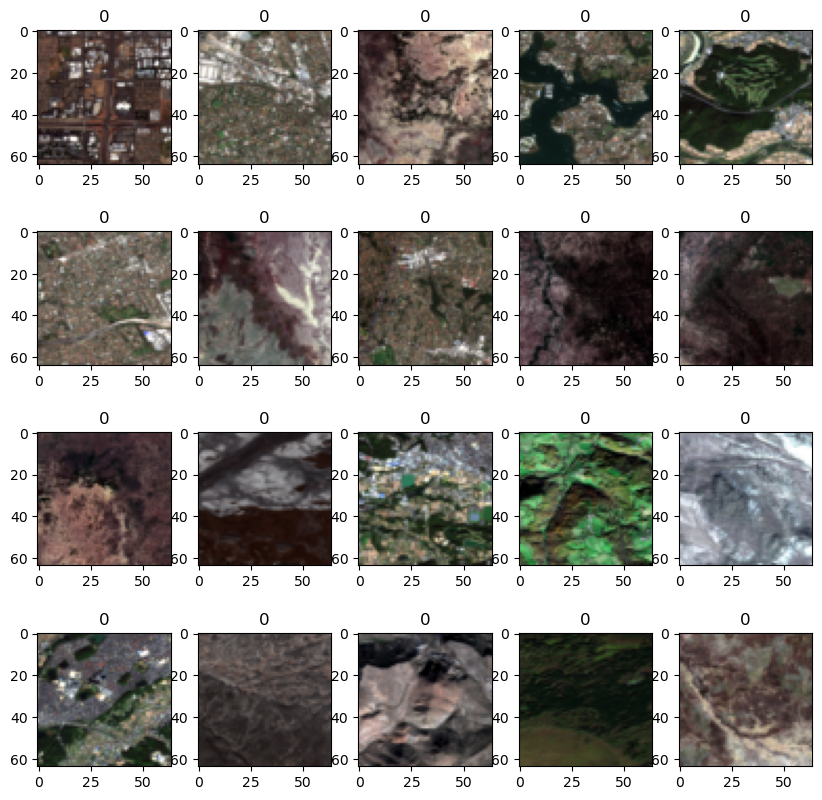

In [5]:
plt.figure(figsize=(10, 10))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(train_dataset[i][0].permute(1, 2, 0))
    plt.title(train_dataset[i][1])

In [6]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

8529 1685 972


In [17]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# training, evaluation

In [8]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (preds == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds == labels).sum().item()

            tbar.set_description(f'Epoc/Epochs [{epoch+1}/{num_epochs}] Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset,valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model

# model

In [9]:
model = timm.create_model(
    'efficientnet_b1',
    pretrained=True,
    num_classes=3
)
model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [10]:
for params in model.parameters():
    params.require_grads = False

for params in model.classifier.parameters():
    params.require_grads = True

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

/var/folders/zt/1l6rrzf977nbpmcz1d2j0vd40000gn/T/ipykernel_52624/3007432345.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(outputs)


Train Loss: 0.21220690725424377, Train Accuracy: 0.974909133544378, Valid Loss: 0.08251957551690617, Valid Accuracy: 0.9893175074183976


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.04676774683668695, Train Accuracy: 0.9942548950638996, Valid Loss: 0.02588643448747545, Valid Accuracy: 0.9970326409495549


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.01859954560098414, Train Accuracy: 0.9970688240121937, Valid Loss: 0.00038960956581976, Valid Accuracy: 1.0


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.029119492867988064, Train Accuracy: 0.9964825888146325, Valid Loss: 0.009099032974284691, Valid Accuracy: 0.9994065281899109


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.037941244293310084, Train Accuracy: 0.9940204009848751, Valid Loss: 0.030067378316289764, Valid Accuracy: 0.9964391691394658


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.003827434778467807, Train Accuracy: 0.9991792707234143, Valid Loss: 0.010157146580386467, Valid Accuracy: 0.998813056379822


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.005216605117334072, Train Accuracy: 0.9991792707234143, Valid Loss: 0.02037778813066899, Valid Accuracy: 0.998813056379822


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0010131470768205261, Train Accuracy: 0.9996482588814632, Valid Loss: 0.012674394618386138, Valid Accuracy: 0.998813056379822


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0014449925901419427, Train Accuracy: 0.999531011841951, Valid Loss: 0.02102517267757618, Valid Accuracy: 0.9994065281899109


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.0064452092729124074, Train Accuracy: 0.9983585414468285, Valid Loss: 0.002335095230866444, Valid Accuracy: 0.998813056379822


# test

In [18]:
model.eval()
total_preds = []
total_labels = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        max_prob, preds = torch.max(probs, 1)
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

  0%|          | 0/16 [00:00<?, ?it/s]

In [19]:
print(total_labels)
print(total_preds)

[0, 2, 0, 1, 1, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 1, 1, 0, 2, 2, 2, 2, 1, 0, 0, 1, 0, 2, 2, 1, 2, 2, 0, 1, 0, 0, 1, 0, 2, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 0, 1, 1, 1, 0, 2, 0, 0, 1, 2, 2, 2, 0, 1, 0, 2, 1, 0, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 0, 2, 0, 1, 2, 2, 0, 1, 0, 0, 1, 2, 2, 0, 1, 0, 0, 0, 1, 0, 2, 1, 1, 1, 0, 2, 2, 0, 1, 1, 1, 1, 0, 0, 2, 1, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 1, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 1, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2, 0, 0, 1, 1, 0, 2, 0, 1, 0, 2, 2, 0, 0, 1, 0, 0, 1, 1, 2, 0, 2, 2, 2, 0, 1, 2, 0, 0, 1, 1, 2, 0, 2, 0, 2, 2, 1, 0, 0, 0, 2, 1, 0, 2, 0, 2, 1, 2, 1, 2, 2, 0, 2, 1, 2, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 0, 1, 2, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0, 0, 1, 2, 2, 0, 2, 2, 0, 1, 1, 0, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 2, 0, 1, 1, 0, 1, 0, 2, 1, 1, 2, 0, 1, 1, 0, 2, 0, 1, 1, 1, 0, 2, 2, 

In [20]:
accuracy_score(total_labels, total_preds)

1.0